In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation
%matplotlib inline

Using TensorFlow backend.


### loading preprocessed dataset

In [2]:
load_df = pd.read_csv('C:/Users/Gj/Documents/Git/macedonian_stock_exchange_market/tmp/mse_raw.csv', 
                      parse_dates=['date', 'start_date'], index_col='Unnamed: 0')

In [3]:
load_df.head(5)

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


## feature engineering

In [4]:
# dates - (year, month, day etc...)
# rolling - (QTY, volume, volumne total etc...) depend on target (1day, 7days, 30days up to 1 year)
# target closing price - (1day, 7days, 30days, 2months etc)
# target QTY - (1day, 7days, 30days, 2months etc)

In [5]:
df_final = load_df.copy()

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

### date extraction

In [7]:
df_final['sale_year'] = df_final.date.dt.year
df_final['sale_month'] = df_final.date.dt.month
df_final['sale_week'] = df_final.date.dt.week
df_final['sale_day'] = df_final.date.dt.day
df_final['sale_dayofweek'] = df_final.date.dt.dayofweek
df_final['sale_dayofyear'] = df_final.date.dt.dayofyear
df_final['is_month_end'] = df_final.date.dt.is_month_end
df_final['is_month_start'] = df_final.date.dt.is_month_start
df_final['is_quarter_end'] = df_final.date.dt.is_quarter_end
df_final['is_quarter_start'] = df_final.date.dt.is_quarter_start
df_final['is_year_end'] = df_final.date.dt.is_year_end
df_final['is_year_start'] = df_final.date.dt.is_year_start
df_final['days_in_month'] = df_final.date.dt.days_in_month
df_final['is_leap_year'] = df_final.date.dt.is_leap_year
#df_final['sales_elapsed'] = df_final.date - df_final.start_date
# converting object into integer
#df_final['sales_elapsed'] = df_final.sales_elapsed.dt.days

In [8]:
display_all(df_final.tail(2))

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date,sale_year,sale_month,sale_week,sale_day,sale_dayofweek,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year
189837,VITA,2020-08-24,14080.0,14080.0,14080.0,14080.0,14080.0,0.0,0.0,0.0,0.0,1998-10-13,2020,8,35,24,0,237,False,False,False,False,False,False,31,True
189859,VITA,2020-08-25,14080.0,14080.0,14080.0,14080.0,14080.0,0.0,0.0,0.0,0.0,1998-10-13,2020,8,35,25,1,238,False,False,False,False,False,False,31,True


### rolling

In [9]:
df_final = df_final.set_index('date')

In [10]:
df_final.head(3)

,stock_id,open,high,low,average,close,volume,quantity,change %,volume total,...,sale_dayofweek,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year
date,,,,,,,,,,,,,,,,,,,,,
1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,...,3,9,False,False,False,False,False,False,31,False
1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,4,10,False,False,False,False,False,False,31,False
1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,5,11,False,False,False,False,False,False,31,False


In [11]:
#rolloing list for 7 days target shifted by 7 days
sum_7_qty_by_stock = []
volumne_moving_avg_7 = []
close_moving_avg_7 = []
average_moving_avg_7 = []
close_volatility_7 = []
max_7_days = []
min_7_days = []
change_by_stock_daily_prev = []
profitability_daily_prev = []
ratio_prev = []

In [12]:
for stock in df_final.stock_id.unique():
    # sum quantity over last 7 days
    qty_sum_7 = df_final[df_final.stock_id == stock].quantity.rolling(7).sum()
    sum_7_qty_by_stock.append(qty_sum_7)
    # moving average on volumne over last 7 days
    volumne_ma_7 = df_final[df_final.stock_id == stock].volume.rolling(7).mean()
    volumne_moving_avg_7.append(volumne_ma_7)
    # moving average on close price over last 7 days
    close_ma_7 = df_final[df_final.stock_id == stock].close.rolling(7).mean()
    close_moving_avg_7.append(close_ma_7)
    # moving average on average price over last 7 days
    avg_ma_7 = df_final[df_final.stock_id == stock].average.rolling(7).mean()
    average_moving_avg_7.append(avg_ma_7)
    # volatility in close price over last 7 days
    close_volatility_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).std() #shift()
    close_volatility_7.append(close_volatility_7_by_stock)
    # max close price in last 7 days
    max_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).max()
    max_7_days.append(max_7_by_stock)
    # min close price in last 7 days
    min_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).min()
    min_7_days.append(min_7_by_stock)
    # ratio overall will be average price devided by max closing price over all time
    mean_close_price = df_final[df_final.stock_id == stock].close.mean()
    ratio_by_stock_prev = df_final[df_final.stock_id == stock].close / mean_close_price
    ratio_prev.append(ratio_by_stock_prev)
    
    # daily_change new feature
    today = df_final[df_final.stock_id == stock].close
    yesterday = today.shift(1)
    change_by_stock =  today / yesterday - 1
    change_by_stock_daily_prev.append(change_by_stock)
    
    # daily_profitability_prev new feature
    profitability_by_stock_prev = df_final[df_final.stock_id == stock].close - df_final[df_final.stock_id == stock].open
    profitability_daily_prev.append(profitability_by_stock_prev)

In [13]:
chain_object_1 = itertools.chain.from_iterable(sum_7_qty_by_stock)
flattened_list_1 = list(chain_object_1)

chain_object_3 = itertools.chain.from_iterable(volumne_moving_avg_7)
flattened_list_3 = list(chain_object_3)

chain_object_5 = itertools.chain.from_iterable(close_moving_avg_7)
flattened_list_5 = list(chain_object_5)

chain_object_16 = itertools.chain.from_iterable(average_moving_avg_7)
flattened_list_16 = list(chain_object_16)

chain_object_7 = itertools.chain.from_iterable(close_volatility_7)
flattened_list_7 = list(chain_object_7)

chain_object_9 = itertools.chain.from_iterable(max_7_days)
flattened_list_9 = list(chain_object_9)

chain_object_11 = itertools.chain.from_iterable(min_7_days)
flattened_list_11 = list(chain_object_11)

ratio_object = itertools.chain.from_iterable(ratio_prev)
flattened_list_13 = list(ratio_object)

change_daily_object = itertools.chain.from_iterable(change_by_stock_daily_prev)
flattened_list_14 = list(change_daily_object)

profitability_object = itertools.chain.from_iterable(profitability_daily_prev)
flattened_list_15 = list(profitability_object)

In [14]:
rolling_7_days = pd.DataFrame({'sum_7_qty_by_stock':flattened_list_1,
                               'moving_avg_volume_7_days':flattened_list_3,
                               'moving_avg_close_7_days':flattened_list_5,
                               'moving_avg_average_7_days':flattened_list_16,
                               'volatility_7_days':flattened_list_7,
                               'max_7_days':flattened_list_9,
                               'min_7_days':flattened_list_11,
                               'ratio_overall_prev':flattened_list_13,
                               'change_daily_prev':flattened_list_14,
                               'profitability_daily_prev':flattened_list_15
                              }
                             )

In [15]:
print(df_final.shape, rolling_7_days.shape)

(164754, 25) (164754, 10)


In [16]:
df_7_days = pd.concat([df_final.reset_index(), rolling_7_days], axis=1)

In [17]:
len(df_7_days.columns)

36

In [18]:
ratio_7_days = []

# Calculating average ratios up to 7 days
for stock in df_7_days.stock_id.unique():
    ratio_7 = df_7_days[df_7_days.stock_id == stock].average / df_7_days[df_7_days.stock_id == stock].average.mean()
    ratio_7_days.append(ratio_7)


In [19]:
chain_object_16 = itertools.chain.from_iterable(ratio_7_days)
flattened_list_16 = list(chain_object_16)

ratios_df = pd.DataFrame({'ratio_7_days':flattened_list_16
                         }
                        )

In [20]:
df_7_days = pd.concat([df_7_days, ratios_df], axis=1)

In [21]:
len(df_7_days.columns)

37

In [22]:
### Add column based on data analysis for close price
#7 days
df_7_days['prevClose_7'] = df_7_days.groupby(['stock_id'])['close'].shift(-7)
df_7_days['returnsClosePrevRaw_7'] = (df_7_days.close.shift(-8) - df_7_days.prevClose_7) / df_7_days.prevClose_7

#14 days
df_7_days['prevClose_14'] = df_7_days.groupby(['stock_id'])['close'].shift(-14)
df_7_days['returnsClosePrevRaw_14'] = (df_7_days.close.shift(-15) - df_7_days.prevClose_14) / df_7_days.prevClose_14

#21 days
df_7_days['prevClose_21'] = df_7_days.groupby(['stock_id'])['close'].shift(-21)
df_7_days['returnsClosePrevRaw_21'] = (df_7_days.close.shift(-22) - df_7_days.prevClose_21) / df_7_days.prevClose_21

#30 days
df_7_days['prevClose_30'] = df_7_days.groupby(['stock_id'])['close'].shift(-30)
df_7_days['returnsClosePrevRaw_30'] = (df_7_days.close.shift(-30) - df_7_days.prevClose_30) / df_7_days.prevClose_30

In [23]:
### Add column based on data analysis for average price

# 1 day
#df_7_days['prevopen_1'] = df_7_days.groupby(['stock_id'])['open'].shift(1)
#(open - prevopen) / prevopen
#df_7_days['returnsOpenPrevRaw1'] = (df_7_days.open - df_7_days.prevopen_1) / df_7_days.prevopen_1

#7 days
df_7_days['prevopen_7'] = df_7_days.groupby(['stock_id'])['open'].shift(-7)
df_7_days['returnsOpenPrevRaw_7'] = (df_7_days.open.shift(-8) - df_7_days.prevopen_7) / df_7_days.prevopen_7

#7 days
df_7_days['prevaverage_7'] = df_7_days.groupby(['stock_id'])['average'].shift(-7)
df_7_days['returnsAvgPrevRaw_7'] = (df_7_days.average.shift(-8) - df_7_days.prevaverage_7) / df_7_days.prevaverage_7

#14 days
df_7_days['prevaverage_14'] = df_7_days.groupby(['stock_id'])['average'].shift(-14)
df_7_days['returnsAvgPrevRaw_14'] = (df_7_days.average.shift(-15) - df_7_days.prevaverage_14) / df_7_days.prevaverage_14

#21 days
df_7_days['prevaverage_21'] = df_7_days.groupby(['stock_id'])['average'].shift(-21)
df_7_days['returnsAvgPrevRaw_21'] = (df_7_days.average.shift(-22) - df_7_days.prevaverage_21) / df_7_days.prevaverage_21

#30 days
df_7_days['prevaverage_30'] = df_7_days.groupby(['stock_id'])['average'].shift(-30)
df_7_days['returnsAvgPrevRaw_30'] = (df_7_days.average.shift(-30) - df_7_days.prevaverage_30) / df_7_days.prevaverage_30

#60 days
df_7_days['prevaverage_60'] = df_7_days.groupby(['stock_id'])['average'].shift(-60)
df_7_days['returnsAvgPrevRaw_60'] = (df_7_days.average.shift(-60) - df_7_days.prevaverage_60) / df_7_days.prevaverage_60

#Rate of change

# pct_chg = lambda x:x.pct_change()
# df_7_days['pct'] = df_7_days.groupby(['stock_id'])['close'].apply(pct_chg)

#Z-score
# zscore = lambda x:(x-x.mean())/x.std()
# df_7_days['z_score'] = df_7_days.groupby(['stock_id'])['close'].apply(zscore)

#percentile transformation
#rollrank = lambda x: x.rolling(200, min_periods=20).apply(lambda x:pd.Series(x).rank(pct=True)[0])
#df_7_days['percentile'] = df_7_days.groupby(['stock_id'])['volume'].apply(rollrank)

### setting ALK, GRNT, KMB, MPT dataset for training, validation and test

In [24]:
print(df_7_days.stock_id.unique())

['ALK' 'BESK' 'FERS' 'GRNT' 'KMB' 'MPT' 'MTUR' 'OKTA' 'PKB' 'PPIV' 'REPL'
 'SBT' 'STBP' 'STB' 'STIL' 'TEL' 'TKVS' 'TNB' 'TTK' 'UNI' 'USJE' 'VITA']


In [25]:
stocks = ['ALK', 'GRNT', 'KMB', 'MPT']

In [26]:
select_df = df_7_days[df_7_days.stock_id.isin(stocks)]

In [27]:
#select_df.sort_values(by=['stock_id', 'date'], ascending=True, inplace=True)

In [28]:
to_drop = ['date','start_date','change %']#, 'open', 'high', 'low', 'average','volume', 'quantity', 'change %', 'volume total']

In [29]:
select_df = select_df.dropna()

In [30]:
select_df.drop(to_drop, axis=1, inplace=True)

In [31]:
len(select_df.columns)

54

In [32]:
each_stock_list = []

for stock in stocks:
    each_stock = select_df[select_df.stock_id == stock]
    each_stock['close'] = each_stock['close'].shift(-7, fill_value=0)
    each_stock_list.append(each_stock)

C:\Users\Gj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [33]:
df = pd.concat(each_stock_list)

In [34]:
df = df.dropna() #subset=df.columns[:-1]

In [35]:
encoder = LabelEncoder()

In [36]:
df['stock_id'] = encoder.fit_transform(df.stock_id)

In [37]:
df.stock_id.unique()

array([0, 1, 2, 3])

In [38]:
scaler = MinMaxScaler()

### split dataset

In [59]:
X_list = []
y_list = []

for stock in range(4):
    each_stock = df[df.stock_id == stock]
    X, y = each_stock.drop(['close'], axis=1), each_stock.close
    #X = scaler.fit_transform(X)
    X_list.append(X)
    y_list.append(y)

In [60]:
def split_vals(dataset, n_test):
    n = dataset.shape[0] - n_test
    train_valid = dataset[:n].copy()
    return train_valid[:-n_test].copy(), train_valid[-n_test:n].copy(), dataset[-n_test:]

import math

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(model, X_train, y_train, X_valid, y_valid):
    res = [np.sqrt(mean_squared_error(model.predict(X_train), y_train)), 
           np.sqrt(mean_squared_error(model.predict(X_valid), y_valid)),
           model.score(X_train, y_train),
           model.score(X_valid, y_valid)]
    if hasattr(model, 'oob_score_'):
        res.append(model.oob_score_)
    print(res)

### creating models for 4 different types of stocks

In [61]:
rf_reg = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5)
xgb_reg = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, 
                           learning_rate=0.05, n_estimators=400, 
                           gamma=0.02, max_depth=15)

n_test = 7

rf_predictions = []
xgb_predictions = []
rf_scores = []
xgb_scores = []
y_test_list = []

### split the dataset on train, valid and test set
### make predictions and add them in lists

In [62]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import IPython
import graphviz
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [63]:
#draw_tree(rf_reg.estimators_[0], X_train, precision=3)

In [64]:
#pd.DataFrame(rf_reg.predict(X_train)).to_excel('train_prediction.xlsx')

ALK
[6.913050069058517, 38.79684610708927, 0.9999942594615133, 0.8885993720792168]
ALK
[0.15641615171624737, 28.48373409734298, 0.9999999970611568, 0.9399533697572767]


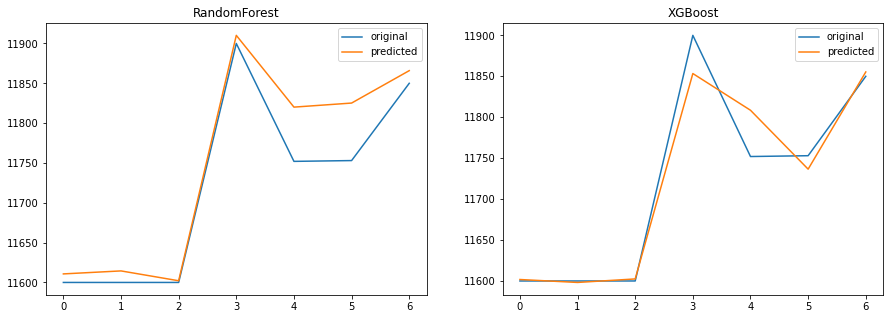

GRNT
[1.9541741204643075, 1.376168334802928, 0.9999838073170235, 0.9360894455922874]
GRNT
[0.05014808013316479, 6.359592609173711, 0.9999999893364717, -0.36485984130729143]


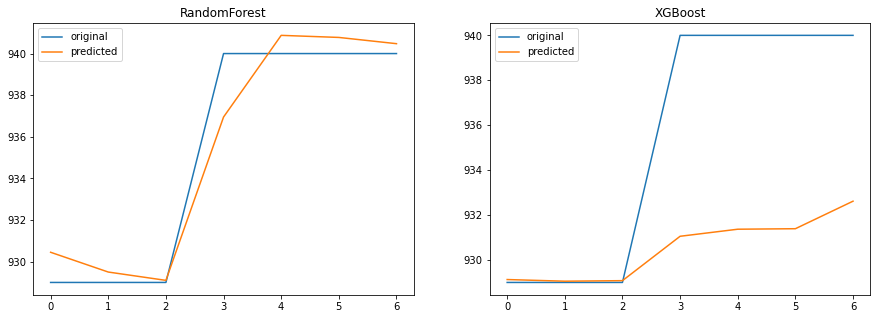

KMB
[9.304065087454553, 10.688979638594283, 0.9999694705512098, 0.9130997764808165]
KMB
[0.16603643217337202, 18.166834075005568, 0.9999999902774482, 0.7489808277174596]


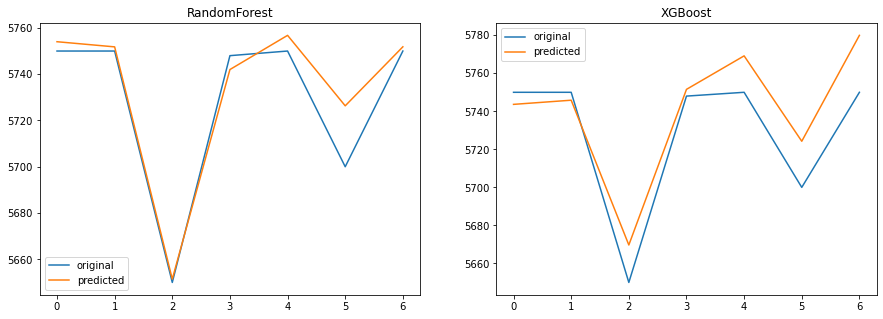

MPT
[97.1353885154551, 119.93712564149325, 0.9999878391884376, 0.9749077797596429]
MPT
[1.096811138378593, 334.79059573063927, 0.9999999984495017, 0.804485794233269]


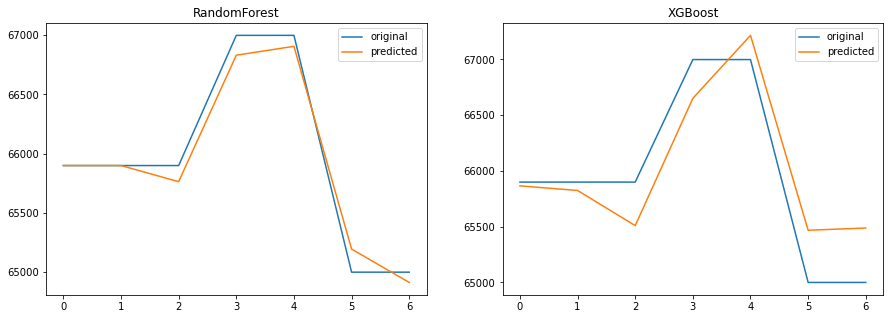

In [65]:
for i in range(4):
    X_train, X_valid, X_test = split_vals(X_list[i], n_test)
    y_train, y_valid, _ = split_vals(y_list[i], n_test)
    rf_reg.fit(X_train, y_train)
    print(encoder.inverse_transform([i])[0]), print_score(rf_reg, X_train, y_train, X_valid, y_valid)
    xgb_reg.fit(X_train, y_train)
    print(encoder.inverse_transform([i])[0]), print_score(xgb_reg, X_train, y_train, X_valid, y_valid)
    
    rf_predictions.append(rf_reg.predict(X_test))
    xgb_predictions.append(xgb_reg.predict(X_test))
    rf_scores.append(rf_reg.score(X_valid, y_valid))
    xgb_scores.append(xgb_reg.score(X_valid, y_valid))

    x_ax = range(len(y_valid))
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    ax1.plot(x_ax, y_valid, label="original")
    ax1.plot(x_ax, rf_reg.predict(X_valid), label="predicted")
    ax1.set_title('RandomForest')
    ax1.legend()
    ax2.plot(x_ax, y_valid, label="original")
    ax2.plot(x_ax, xgb_reg.predict(X_valid), label="predicted")
    ax2.set_title('XGBoost')
    ax2.legend()
    plt.show()

### results

In [80]:
import datetime
last_day = df_7_days.date.max()
prediction_date = last_day + datetime.timedelta(days=7)

In [91]:
print('Random Forest results are:','\n')
for i in range(4):
    print('Price for {} on {} will be:'.format(stocks[i], prediction_date.date()), np.round(rf_predictions[i][-1],0))

Random Forest results are: 

Price for ALK on 2020-09-01 will be: 11994.0
Price for GRNT on 2020-09-01 will be: 950.0
Price for KMB on 2020-09-01 will be: 5891.0
Price for MPT on 2020-09-01 will be: 64382.0


In [92]:
print('XGBoost results are:','\n')
for i in range(4):
    print('Price for {} on {} will be:'.format(stocks[i], prediction_date.date()), np.round(xgb_predictions[i][-1],0))

XGBoost results are: 

Price for ALK on 2020-09-01 will be: 11869.0
Price for GRNT on 2020-09-01 will be: 952.0
Price for KMB on 2020-09-01 will be: 5886.0
Price for MPT on 2020-09-01 will be: 64705.0
